# NLP Continue

In [1]:
# getting the helper function

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-12 17:14:11--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-12 17:14:12 (78.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

# Getting the dataset for binary text classification

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

--2024-06-12 17:14:49--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.207, 74.125.197.207, 74.125.135.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2024-06-12 17:14:49 (155 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [4]:
unzip_data("nlp_getting_started.zip")

# Visualizing the dataset

In [5]:
import pandas as pd

train_df = pd.read_csv("train.csv")

In [6]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [7]:
train_df["target"].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [9]:
train_df_shuffled = train_df.sample(frac=1, random_state=2)
train_df_shuffled.head()

,id,keyword,location,text,target
3190,4579,emergency%20plan,North Hastings Ontario,Practice your families fire escape plan so eve...,0
6171,8801,sirens,"Nomad, USA",Fuck Sleeping With Sirens.,0
1196,1722,buildings%20burning,NaN,'i'm a Gemini' *children screaming buildings b...,1
680,982,blazing,"Pig Symbol, Alabama",Montgomery come for the blazing hot weather......,1
3358,4808,evacuated,NaN,I got evacuated from the cinema 30 mins throug...,0


In [10]:
## Visualizing the random training examples

import random

random_index = random.randint(0, len(train_df) -5)

for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("_______________________________________________________________")

Target: 1 (real disaster)
Text:
Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM: Investigators and the families of those who were... http://t.co/SfAKQNveta

_______________________________________________________________
Target: 0 (not real disaster)
Text:
I still have not heard Church Leaders of Kenya coming forward to comment on the accident issue and disciplinary measures#ArrestPastorNganga

_______________________________________________________________
Target: 0 (not real disaster)
Text:
Are Users of this Sub to be Quarantined? http://t.co/9nLY2TovUD

_______________________________________________________________
Target: 1 (real disaster)
Text:
@AlexAllTimeLow awwww they're on an airplane accident and they're gonna die what a cuties ???? good job!

_______________________________________________________________
Target: 0 (not real disaster)
Text:
Photo: forrestmankins: Colorado camping. http://t.co/S0VgTkhW7V

_________________________________________________________

# Splitting the dataset into training and validation dataset

In [11]:
from sklearn.model_selection import train_test_split

In [13]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size = 0.1,
    random_state=2
)

In [14]:
train_sentences.shape, val_sentences.shape

((6851,), (762,))

# Tokenization

In [15]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [16]:
text_vectorizer = TextVectorization(
    max_tokens = None,
    standardize = "lower_and_strip_punctuation",
    split = "whitespace",
    ngrams = None,
    output_mode = "int",
    output_sequence_length = None
)

In [17]:
round(sum([len(i.split()) for i in train_sentences]) / len(train_sentences))

15

In [18]:
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(
    max_tokens = max_vocab_length,
    output_sequence_length = max_length,
    pad_to_max_tokens = True
)

In [19]:
text_vectorizer.adapt(train_sentences)

In [20]:
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

In [21]:
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 most common words: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 most common words: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 most common words: ['palm', 'palinfoen', 'palestinian\x89Û', 'paleface', 'pale']


# Embedding

In [22]:
from tensorflow.keras import layers

embedding = layers.Embedding(
    input_dim = max_vocab_length,
    output_dim = 128,
    input_length = max_length
)

In [23]:
random_sentence = random.choice(train_sentences)

print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

sample_embed = embedding(text_vectorizer([random_sentence]))

sample_embed

Original text:
louis is sad. cancel the show now. everyone leave. evacuate. this CANNOT go on.      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.03746605, -0.01826876, -0.03039565, ...,  0.01219721,
          0.00550097,  0.00550486],
        [ 0.04873544, -0.02107739,  0.00631924, ..., -0.002986  ,
         -0.04702355,  0.01376316],
        [ 0.03508839,  0.01653062, -0.02276899, ...,  0.03274495,
         -0.01337041, -0.04432768],
        ...,
        [-0.01353549, -0.04047514, -0.04174018, ..., -0.02128415,
          0.02892366,  0.00988243],
        [-0.02984217, -0.02998874, -0.03548795, ..., -0.01592588,
         -0.03048928,  0.01654272],
        [ 0.02347436, -0.03584542,  0.00802032, ...,  0.04081453,
          0.04421118,  0.03067757]]], dtype=float32)>

In [24]:
sample_embed.shape

# 1 sample
# 15 tokens
# 128 vector each

TensorShape([1, 15, 128])

# Modelling

* Model 0: Naive Bayes ✅
* Model 1: Feed-Forward neural network (dense model) ✅
* Model 2: LSTM ✅
* Model 3: GRU ✅
* Model 4: Bidirectional-LSTM ✅

Completed model 0 1 2 3 4 in previous

* Model 5: 1D Convolutional Neural Network
* Model 6: Tensorflow Hub Pretrained Feature Extractor (using transfer learnig for NLP)
* Model 7: Same as model 6 with 10% of training data

# Convolution Neural Networks for Text (and other types of sequence data)

We have used CNNs for images but images are typically 2dimensional (width and height).. however our text data is 1dimensional

Previously we have used Conv2D for image data but now we are using Conv1D for text data (sequence data)

________________________________________________

Typical structure of a Conv1D model for sequences.

Inputs (text) --> Tokenization --> Embeddings --> Conv1Dlayer(s) --> Pooling Layer --> Dense Layer

In [25]:
# training the LSTM

from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(128, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model_test = tf.keras.Model(
    inputs,
    outputs,
    name="model_test"
)

In [26]:
model_test.summary()

Model: "model_test"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 15, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                        

In [27]:
model_test.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_test_history = model_test.fit(
    train_sentences,
    train_labels,
    epochs=5,
    validation_data=(val_sentences, val_labels)
)

Epoch 1/5
215/215 [==============================] - 17s 55ms/step - loss: 0.5065 - accuracy: 0.7533 - val_loss: 0.4696 - val_accuracy: 0.7913
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3148 - accuracy: 0.8711 - val_loss: 0.5253 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 2s 9ms/step - loss: 0.2186 - accuracy: 0.9180 - val_loss: 0.5737 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 3s 13ms/step - loss: 0.1542 - accuracy: 0.9425 - val_loss: 0.8724 - val_accuracy: 0.7415
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1016 - accuracy: 0.9607 - val_loss: 0.8735 - val_accuracy: 0.7493


<Axes: >

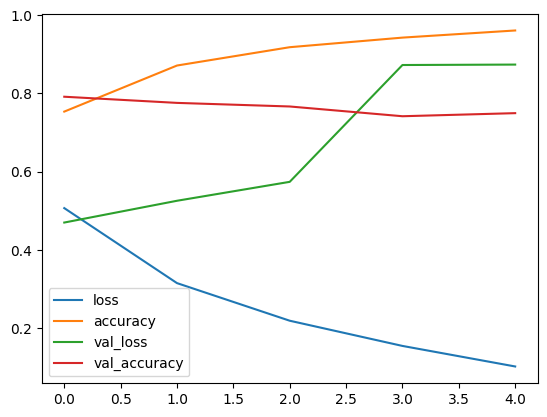

In [28]:
# plotting the loss curve of model_test_history

loss = pd.DataFrame(model_test_history.history)
loss.plot()

# Model 5: Conv1D (cnn for text)

In [29]:
embedding_test = embedding(text_vectorizer(["Hello this is for testing the embedding in Conv1D"]))

conv_1d = layers.Conv1D(
    filters = 32,
    kernel_size = 5,
    activation = "relu",
    padding = "valid" # "same" -> inputs are preserved "valid"-> some inputs dropped if kernel not met requirements
)

conv_1d_output = conv_1d(embedding_test)
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output)

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [30]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(
    filters = 64,
    kernel_size = 5,
    activation = "relu",
    padding = "valid"
)(x)
x = layers.GlobalMaxPool1D()(x)
output_conv1d = layers.Dense(1, activation="sigmoid")(x)

model_5 = tf.keras.Model(
    inputs,
    output_conv1d,
    name="model_5"
)

In [31]:
model_5.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_2 (Dense)             (None, 1)                 65  

In [33]:
model_5.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_5_history = model_5.fit(
    train_sentences,
    train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels)
)

Epoch 1/5
215/215 [==============================] - 9s 32ms/step - loss: 0.2309 - accuracy: 0.9273 - val_loss: 0.7172 - val_accuracy: 0.7507
Epoch 2/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1153 - accuracy: 0.9604 - val_loss: 0.8616 - val_accuracy: 0.7467
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.0831 - accuracy: 0.9717 - val_loss: 0.9565 - val_accuracy: 0.7507
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0679 - accuracy: 0.9777 - val_loss: 1.0472 - val_accuracy: 0.7480
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0618 - accuracy: 0.9783 - val_loss: 1.0578 - val_accuracy: 0.7454


In [34]:
model_5_pred_probs = model_5.predict(val_sentences)

model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))

model_5_preds[:5]

24/24 [==============================] - 1s 13ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 0., 1., 0., 0.], dtype=float32)>

# Evaluation function

In [35]:
## Creating a function to track evaluation methods
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_preds(y_true, y_pred):
  """Evaluate your prediction

  parameters:
  y_true = true labels
  y_pred = predicted labels
  """
  accuracy = accuracy_score(y_true, y_pred) * 100
  precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average = "weighted")

  model_results = {
      "accuracy": accuracy,
      "precision": precision * 100,
      "recall": recall * 100,
      "f1": f1 * 100
  }
  return model_results

In [36]:
print(evaluate_preds(val_labels, model_5_preds))

{'accuracy': 74.54068241469817, 'precision': 74.70943067101133, 'recall': 74.54068241469817, 'f1': 74.32209231421831}


# Model 6: Hub Pretrained Feature Extractor

https://www.tensorflow.org/text/guide/word_embeddings

USE - universal sentence encoder

encoder -> encode text
decoder -> outputs text

Inputs(text) -> Embedding layer (pretrained) -> Dense layer -> Output



In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_sample = embed(["Hi this is testing for pretrained embedding model"])



In [40]:
embed_sample.shape

TensorShape([1, 512])

In [44]:
embed_nepali = embed(["mero naam ram ho"])

embed_nepali[0][:50]

<tf.Tensor: shape=(50,), dtype=float32, numpy=
array([ 0.0408464 , -0.02495966,  0.0035716 ,  0.01267226,  0.04208707,
       -0.05816627,  0.01271041, -0.07358219,  0.00701732,  0.03845023,
       -0.00651939,  0.05063221, -0.03839327, -0.03659068, -0.06967411,
       -0.04780556,  0.00481468,  0.05042034,  0.05477953, -0.02568754,
        0.00770516, -0.03293319, -0.01063942, -0.07826257, -0.04656087,
        0.024152  ,  0.03084197, -0.06599965, -0.05757726,  0.03078692,
       -0.01469202, -0.05266828, -0.08241986,  0.00048551,  0.02130463,
       -0.03029221, -0.03983517,  0.03594345, -0.07638883,  0.05466463,
       -0.01398564, -0.05250673, -0.04226359, -0.04101405, -0.03595319,
       -0.01774598, -0.0172534 , -0.00611795,  0.04797418,  0.01700241],
      dtype=float32)>

In [45]:
# Creating keras layer using the USE pretrained layer from tensorflow Hub

sentence_encoder_layer = hub.KerasLayer(
    "https://tfhub.dev/google/universal-sentence-encoder/4",
    input_shape = [], # because of variable length input text
    dtype = tf.string,
    trainable = False, # dont train further only use the pretrained weights that comes with this
    name = "USE"
)

In [46]:
# Create model using the Sequential API

model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6")

In [47]:
model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_3 (Dense)             (None, 64)                32832     
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [49]:
model_6.compile(
    loss = "binary_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_6_history = model_6.fit(
    train_sentences,
    train_labels,
    epochs = 5,
    validation_data = (val_sentences, val_labels)
)

Epoch 1/5
215/215 [==============================] - 8s 25ms/step - loss: 0.5057 - accuracy: 0.7794 - val_loss: 0.4345 - val_accuracy: 0.8045
Epoch 2/5
215/215 [==============================] - 5s 22ms/step - loss: 0.4164 - accuracy: 0.8165 - val_loss: 0.4239 - val_accuracy: 0.8018
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.4015 - accuracy: 0.8235 - val_loss: 0.4219 - val_accuracy: 0.8045
Epoch 4/5
215/215 [==============================] - 6s 26ms/step - loss: 0.3932 - accuracy: 0.8288 - val_loss: 0.4189 - val_accuracy: 0.8058
Epoch 5/5
215/215 [==============================] - 5s 23ms/step - loss: 0.3861 - accuracy: 0.8300 - val_loss: 0.4238 - val_accuracy: 0.8018


In [50]:
model_6_pred_probs = model_6.predict(val_sentences)

model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))

model_6_preds[:5]

24/24 [==============================] - 1s 23ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 0., 1., 0., 0.], dtype=float32)>

In [51]:
print(evaluate_preds(val_labels, model_6_preds))

{'accuracy': 80.18372703412074, 'precision': 80.55201845643882, 'recall': 80.18372703412074, 'f1': 79.99743384212348}
